Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Logistic Regression - Testing Accuracy: 88.77%
Precision: 0.484
Recall: 0.017
F1-Score: 0.033
ROC AUC: 0.507
Specificity: 0.998


Random Forest - Testing Accuracy: 88.80%
Precision: 0.529
Recall: 0.016
F1-Score: 0.031
ROC AUC: 0.507
Specificity: 0.998




/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8796 - loss: 0.3625 - val_accuracy: 0.8879 - val_loss: 0.3330
Epoch 2/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8862 - loss: 0.3352 - val_accuracy: 0.8877 - val_loss: 0.3312
Epoch 3/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8872 - loss: 0.3295 - val_accuracy: 0.8879 - val_loss: 0.3306
Epoch 4/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8875 - loss: 0.3266 - val_accuracy: 0.8881 - val_loss: 0.3298
Epoch 5/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8882 - loss: 0.3263 - val_accuracy: 0.8882 - val_loss: 0.3302
Epoch 6/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8907 - loss: 0.3187 - val_accuracy: 0.8884 - val_loss: 0.3301
Epoch 7/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8903 - loss: 0.3189 - val_accuracy: 0.8882 - val_loss: 0.3305
Epoch 8/50
2227/2227 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8922 - loss: 0.3145 - 

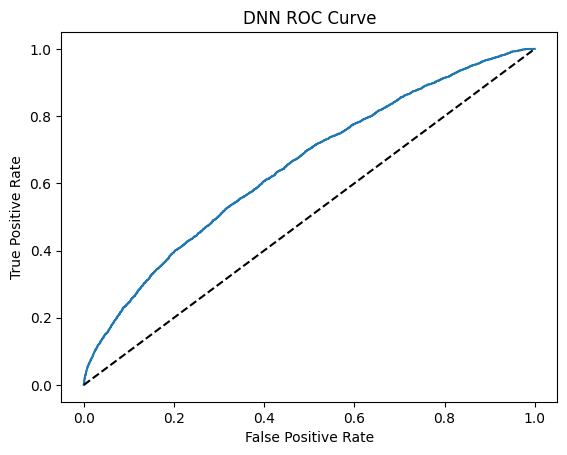

In [ ]:
# 필요한 라이브러리 임포트
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score,f1_score, roc_curve, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')
# 데이터 로드 및 전처리
df = pd.read_csv("/content/drive/MyDrive/기계학습/diabetic_data.csv")

# 'readmitted' 컬럼의 값을 숫자로 변환
df['readmitted'] = df['readmitted'].replace(['NO', '>30', '<30'], ['0', '0', '1']).astype(int)

# 사용할 필요가 없는 열 삭제
df = df.drop(['encounter_id', 'patient_nbr', 'weight', 'examide', 'citoglipton', 'diag_1', 'diag_2', 'diag_3'], axis=1)

# '?' 값을 NaN으로 변환
df.replace('?', np.nan, inplace=True)

# 결측치를 처리하기 위해 'race', 'medical_specialty', 'payer_code' 열의 결측값을 'UKN'으로 채움
df['race'] = df['race'].fillna('UKN')
df['medical_specialty'] = df['medical_specialty'].fillna('UKN')
df['payer_code'] = df['payer_code'].fillna('UKN')

# 'medical_specialty' 컬럼에서 상위 10개 값이 아닌 경우 'Other'로 처리
top_10 = ['UKN', 'InternalMedicine', 'Emergency/Trauma', 'Family/GeneralPractice', 'Cardiology',
          'Surgery-General', 'Nephrology', 'Orthopedics', 'Orthopedics-Reconstructive', 'Radiologist']
df.loc[~df['medical_specialty'].isin(top_10), 'medical_specialty'] = 'Other'

# 'admission_type_id', 'discharge_disposition_id', 'admission_source_id'를 문자열로 변환
df['admission_type_id'] = df['admission_type_id'].astype(str)
df['discharge_disposition_id'] = df['discharge_disposition_id'].astype(str)
df['admission_source_id'] = df['admission_source_id'].astype(str)

# 더미 변수를 이용해 범주형 데이터 처리
categorical_columns = ['race', 'gender', 'payer_code', 'max_glu_serum', 'A1Cresult', 'change', 'diabetesMed',
                       'admission_type_id', 'discharge_disposition_id', 'admission_source_id', 'medical_specialty']
df_cat = pd.get_dummies(df[categorical_columns], drop_first=True)

# 수치형 데이터 결합
df_num_cols = df[['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications',
                  'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses']]
dff = pd.concat([df_cat, df_num_cols, df['readmitted']], axis=1)


# 데이터 분할
df_train, df_test = train_test_split(dff, test_size=0.3, random_state=42)
X_train = df_train.drop('readmitted', axis=1)
y_train = df_train['readmitted']
X_test = df_test.drop('readmitted', axis=1)
y_test = df_test['readmitted']

# 데이터 정규화
scaler = StandardScaler()
X_train_tf = scaler.fit_transform(X_train)
X_test_tf = scaler.transform(X_test)

# Specificity 계산 함수
def calc_specificity(y_actual, y_pred):
    cm = confusion_matrix(y_actual, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    specificity = TN / (TN + FP)
    return specificity

# 일반 머신러닝 모델 적용 (로지스틱 회귀, 랜덤 포레스트)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

for model_name, model in models.items():
    model.fit(X_train_tf, y_train)
    y_test_pred = model.predict(X_test_tf)

    print(f"{model_name} - Testing Accuracy: %.2f%%" % (accuracy_score(y_test, y_test_pred) * 100))
    print("Precision: %.3f" % precision_score(y_test, y_test_pred))
    print("Recall: %.3f" % recall_score(y_test, y_test_pred))
    print("F1-Score: %.3f" % f1_score(y_test, y_test_pred))
    print("ROC AUC: %.3f" % roc_auc_score(y_test, y_test_pred))
    specificity = calc_specificity(y_test, y_test_pred)
    print("Specificity: %.3f" % specificity)
    print("\n")

# 심층 신경망 모델 적용
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 신경망 모델 구축
model = Sequential()
model.add(Dense(32, activation='relu', input_dim=X_train_tf.shape[1]))
model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 모델 컴파일
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 모델 학습
history = model.fit(X_train_tf, y_train, epochs=50, batch_size=32, validation_data=(X_test_tf, y_test))

# 성능 평가
y_test_pred_probs = model.predict(X_test_tf)
y_test_pred = (y_test_pred_probs > 0.5).astype("int32")

print("DNN - Testing Accuracy: %.2f%%" % (accuracy_score(y_test, y_test_pred) * 100))
print("Precision: %.3f" % precision_score(y_test, y_test_pred))
print("Recall: %.3f" % recall_score(y_test, y_test_pred))
print("F1-Score: %.3f" % f1_score(y_test, y_test_pred))
print("ROC AUC: %.3f" % roc_auc_score(y_test, y_test_pred_probs))

# Specificity 계산
specificity = calc_specificity(y_test, y_test_pred)
print("Specificity: %.3f" % specificity)

# ROC Curve 그리기
fpr, tpr, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], '--', color='black')
plt.title("DNN ROC Curve")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()
